# Actividad integradora

## Descripción

Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las cajas en algo parecido al orden y convertirlo en un negocio exitoso.

Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.

## Puntos a considerar

               
    • La semilla para generación de números aleatorios será 67890.
    • El almacén es 20x20 celdas.
    • Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
    • Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
    • La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.

### ¿Qué debes entregar?

Un cuaderno de Jupyter Notebook conteniendo un reporte de la actividad. El cuaderno deberá contener:

    • Código fuente documentado.
    • Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
    • Una visualización que permita ver los diferentes pasos de la simulación.
    • El número de pasos necesarios para terminar la simulación.
    • ¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?

## Criterios de evaluación 

Los criterios que se utilizarán para evaluar sus soluciones y seleccionar a los tres primeros ganadores son los siguientes:

    • Aplicación original, innovadora y efectiva de algoritmos computacionales para resolver problemas específicos.
    • El rendimiento de la implementación. El rendimiento de la implementación se medirá en función los pasos necesarios para terminar la simulación.
    • La calidad de la descripción de análisis, diseño e implementación del sistema multiagente, la elegancia de su diseño e implementación.

# Algoritmo 

- Generar la matriz con cajas aleatorias apiladas de 1 - 3
- Generar los agentes en celdas vacias de manera aleatoria 
- Mover de manera aleatoria a celdas vecinas y vacias a los agentes
    - Si un agente encuentra una pila de cajas menor a 5 toma una y la mueve a la pila de cajas mas cerca
    - El agente se mueve de nuevo aleatoriamente y repite el proceso.

# Imports

In [31]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import pandas as pd

import time as tm

import datetime
import time as tm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Agent

In [32]:
class BoxArrengmentAgent(Agent):
    def __init__ (self, unique_id, model, isCarrying, numBoxes): 
        super().__init__(unique_id, model)
        self.isCarrying = False
        self.numBoxes = numBoxes

    def step(self):
        #si no esta cargando una caja, busca una caja para cargar
        if self.isCarrying == False:
            self.pickUpBox()
        #si esta cargando una caja, busca donde dejarla
        elif self.isCarrying == True:
            self.dropBox()
        #si pasa otra cosa estamos muy mal
        else:
            print("no se que esta pasando, no debería de entrar aqui")
        #Despues de ver si puede tomar o dejar cajas, se mueve
        self.move()
        
        #En caso de que todas las pilas sean de 5 y todos los agentes tengan caja, uno de ellos tiene que dejarla
        if self.model.pilas5 == 39 and self.isCarrying == True and self.unique_id == 1:
            possibleSteps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        
            for step in possibleSteps:
                newX, newY = step
                if self.model.floor[newX][newY] < 5:
                    self.model.floor[newX][newY] += 1
                    self.isCarrying = False
                    self.numBoxes = 0
                    if self.model.floor[newX][newY] == 5:
                        self.model.pilas5 += 1
                        print ("Pilas de 5: ", self.model.pilas5)
                    break

    def pickUpBox(self):
        #Revisa a sus vecinos si hay cajas y que no sean una pila de 5
        possibleSteps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        
        for step in possibleSteps:
            newX, newY = step
            if self.model.floor[newX][newY] > 0 and self.model.floor[newX][newY] < 5:
                self.numBoxes = self.model.floor[newX][newY] #Numero de cajas que tenía la pila donde la tomo (nos servira para saber donde dejarla)
                self.isCarrying = True
                self.model.floor[newX][newY] -= 1
                break
    
    def dropBox(self):
        #revisar con sus vecinos si hay cajas que no sean pilas de 5 y sean del mismo o mayor tamaño de la pila de donde la tomó
        possibleSteps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        
        for step in possibleSteps:
            newX, newY = step
            if self.model.floor[newX][newY] < 5 and self.model.floor[newX][newY] > 0:
                self.model.floor[newX][newY] += 1
                self.isCarrying = False
                self.numBoxes = 0
                if self.model.floor[newX][newY] == 5:
                    self.model.pilas5 += 1
                    #print ("Pilas de 5: ", self.model.pilas5)
                break
    
    def move(self):
        x,y = self.pos
        possibleSteps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False) 
        
        #Sacamos los vecinos de la celda actual que no tengan agentes (aqui puede que tengan cajas)
        emptySteps = [step for step in possibleSteps if self.model.grid.is_cell_empty(step)]
        
        #De esos vecinos sin agentes quitamos las opciopnes que tengan cajas
        for step in emptySteps:
            newX, newY = step
            if self.model.floor[newX][newY] > 0:
                emptySteps.remove(step)

        #Si existe un vecino sin caja ni agente, nos movemos ahí, si hay mas de uno lo selecciona de manera aleatoria
        if emptySteps:
            newX, newY = self.random.choice(emptySteps)
            if not self.model.grid.out_of_bounds((newX, newY)):
                self.model.grid.move_agent(self, (newX, newY))
            #print("Me moví a ", newX, newY)
        else:
            print("No me moví")

        
    



In [33]:
#getGrid
def getGrid(self):
    return self.floor.copy()

# Model

In [34]:
from typing import Any


class BoxArrengmentModel(Model):
    def __init__ (self, width, heigth, totalBoxes, numAgents):
        self.totalBoxes = totalBoxes
        self.grid = SingleGrid(width, heigth, False)
        self.schedule = RandomActivation(self)
        self.numAgents = numAgents
        self.steps = 0
        self.width = width
        self.heigth = heigth
        self.pilas5 = 0 #Contador de pilas de 5
        
        #Semilla random
        np.random.seed(67890)    

        #Create floor
        self.floor = np.zeros((self.width, self.heigth))


        self.datacollector = DataCollector(
            model_reporters = {"Boxes": getGrid, "Agents": getGrid}
        )
        
        #Create Agents and place 
        id = 0
        while(id < self.numAgents):
            x = np.random.randint(0, self.width)
            y = np.random.randint(0, self.heigth)
            if (self.floor[x][y] == 0):
                a = BoxArrengmentAgent(id, self, False, 0)
                self.schedule.add(a)
                self.grid.place_agent(a, (x,y))
                id += 1

        #Create Boxes and place
        count = 0
        while(count < totalBoxes):
            x = np.random.randint(0, self.width)
            y = np.random.randint(0, self.heigth)
            if(self.floor[x][y] ==0):
                num = np.random.randint(1,4)
                if count + num < totalBoxes:
                    self.floor[x][y] += num 
                    count += num
                    #print ("la cuenta va en ", count)
                else:
                    num = totalBoxes - count
                    self.floor[x][y] += num
                    count += num
            
        print ("se generaron exitosamente ", count, "Cajas al inicio.")

    def step(self):
        self.steps += 1 
        self.datacollector.collect(self)
        self.schedule.step() 
           

            

# Simulación

In [35]:
WIDTH = 20
HEIGTH = 20
TOTAL_BOXES = 200
NUM_AGENTS = 5
ITER = 100000

model = BoxArrengmentModel(WIDTH, HEIGTH, TOTAL_BOXES, NUM_AGENTS)

#print(model.floor)
for i in range(ITER):
    model.step()
    if model.pilas5 == TOTAL_BOXES/5:
        print("Se terminó en el paso " , i)
        break


    
print(model.floor)



se generaron exitosamente  200 Cajas al inicio.


No me moví
[[0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 5. 1.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 5. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 5. 0. 5. 0. 0. 0. 0. 5. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 

In [36]:
all_grid = model.datacollector.get_model_vars_dataframe()

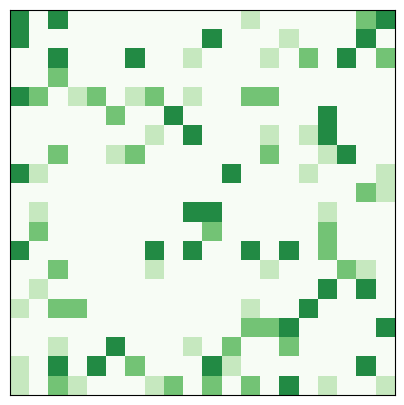

In [37]:
fig, axis = plt.subplots(figsize=(5, 5))
boxData = all_grid.get("Boxes")
axis.set_xticks([])
axis.set_yticks([])
patch = axis.imshow(boxData[10], cmap="Greens")

def animate(i):
    patch.set_data(boxData[i])
    return patch
    
anim = animation.FuncAnimation(fig, animate, frames=ITER)
anim

In [38]:
anim

In [39]:
WIDTH = 20
HEIGTH = 20
TOTAL_BOXES = 200
NUM_AGENTS = 5
ITER = 30000

model = BoxArrengmentModel(WIDTH, HEIGTH, TOTAL_BOXES, NUM_AGENTS)

#print(model.floor)
for i in range(ITER):
    model.step()
    if model.pilas5 == TOTAL_BOXES/5:
        print("Se terminó en el paso " , i)
        break


    
print(model.floor)



se generaron exitosamente  200 Cajas al inicio.


Se terminó en el paso  15920
[[5. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 5. 5. 0. 0. 0. 0. 

/tmp/ipykernel_14454/1826335141.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary_r)
/tmp/ipykernel_14454/1826335141.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


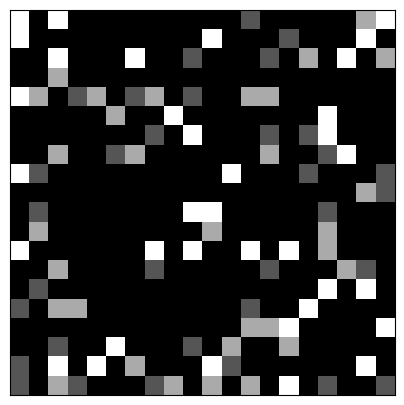

In [40]:
all_grid = model.datacollector.get_model_vars_dataframe()
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary_r)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=ITER)

In [41]:
anim